In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

## A/B test  for Amazon
The goal of running an AB test is to evaluate if a change will lead to improved performance in a specific metric. The change can be very simple alternatives such as changing the look of a single button on a webpage or testing different layouts and headlines. 

In our cases, we find a A/B test case of Amazon on their landing page of releasing Amazon Vehicles. Amazon is a quie popular and famous e-commerce platform. It has done a lot of A/B testing on their services to always on the hunt for a better UX and improved conversion. 
Browsing around the website, we can noticed that on the landing page of Amazon Vehicles, they even do A/B testing for their Popular Body Styles section showing.  
  
A) a gray-ish version of cars and  
B) a very colourful version of cars.  
  
  
</br >
<center>
<img src="amazon.jpg"width=800/>
</center>
  
So, for figuring out whether this difference showing of vehicles' color can lead to a great improvement of user's conversion, which is placing an order or not at here, we can do a A/B test.

## Dataset

In [212]:
ab_data = pd.read_csv("ab_data.csv")
ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,test,colourful version,0
1,804228,01:45.2,test,colourful version,0
2,661590,55:06.2,control,gray-ish version,0
3,853541,28:03.1,control,gray-ish version,0
4,864975,52:26.2,test,colourful version,1


In [213]:
del ab_data['timestamp']

In [214]:
ab_data.isnull().sum()

user_id         0
group           0
landing_page    0
converted       0
dtype: int64

In [215]:
A_group = ab_data[ab_data['group'] == 'control']
B_group = ab_data[ab_data['group'] == 'test']

In [216]:
# total number of people of each group
A_total, B_total = len(A_group), len(B_group)
A_total, B_total

(147239, 147239)

In [217]:
#converted number of people of each group
A_converted, B_converted = A_group['converted'].sum(), B_group['converted'].sum()
A_converted, B_converted

(17498, 17739)

In [218]:
#conversion rate of each group
p_A, p_B = A_converted / A_total, B_converted / B_total
p_A, p_B

(0.11884079625642663, 0.12047759085568362)

In [219]:
#increased rate
p_B - p_A

0.0016367945992569882

In [220]:
summary = ab_data.groupby(['group','landing_page','converted']).count()
summary.rename(columns={'user_id':'number_of user'}, inplace = True)
summary

number_of user
group   landing_page      converted                
control gray-ish version  0                  129741
                          1                   17498
test    colourful version 0                  129500
                          1                   17739

## Null hypothesis test
$$ H_0: \mu1 = \mu2 $$
$$ H_1: \mu2 > \mu1 $$

Null hypothesis test is usually used to test whehther the mean of two groups of data is significant different. It will assume the difference is not significant defauly and do the z test or t test based on this assumption. And accoring to whether the result we get is match to the H_0 hypothesis, it will choose to reject H_0 or not.

### Null hypothesis test with number of converted people

The null hypothesis in our first test is:
* The modify that changing the car's color into colourful from gray in landing page of Amazon Vehicles **would result in no significant change** in the number of the converted people.
  
It states that the difference in number of the converted people between two groups is not significant. So we can plot distributions for two groups, with the means are each group's number of the converted people, to see the sample's diffrence. And because we are comparing two groups of data, so we should use t test to calculate whether we can reject the null hypothesis.

In our case, the result of user can only be converted or not (0 and 1), so for each user they are Bernoulli. And for the whole group, the converted number of people will fit binomial distribution which is repeating Bernoulli experiment for serveral time and get the different probability of different converted number of people. So we should plot our gragh with binomial distribution.

Text(0, 0.5, 'probability')

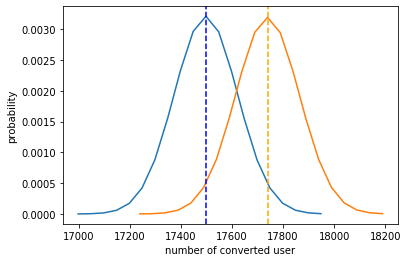

In [221]:
x_A = np.arange(A_converted-500, A_converted+500,50)
y_A = stats.binom(A_total, p_A).pmf(x_A)

x_B = np.arange(B_converted-500, B_converted+500,50)
y_B = stats.binom(B_total, p_B).pmf(x_B)

plt.plot(x_A,y_A)
plt.plot(x_B,y_B)

plt.axvline(x=A_converted,ls="--",c="blue")
plt.axvline(x=B_converted,ls="--",c="orange")

plt.xlabel('number of converted user')
plt.ylabel('probability')

In the diagram, the blue curve is the control group and the orange curve is test group. The dash lines are the means which are also the converted number of people for two groups. According to the diagram, we can the area behind the orange dash line but under the blue curve is quite small. So it seems like the test group has a certain distance  from control group. But we still have to use t test to get the precise value. 

Because the y in the above diagram is the probability, so then, I generate two group of data through generating data randomly  from bimomial distrubtion with each group's sample size and converted probabilty. For example, we test A_total users at a time, each user is with a converted probability of p_A, and after 20000 tests, we can get a group data of the number of converted users in each test. Then the funtion of t test will calculate the mean of two groups' number of converted users automatically and calculate the t value and p value.

In [226]:
simulation_A = np.random.binomial(A_total, p_A, 2000)
simulation_B = np.random.binomial(B_total, p_B, 2000)

Before doing t test, we should first test whether the variance of the two groups is similar and we can do it by f test. 

In [227]:
# f-tests
stats.levene(simulation_A,simulation_B)

LeveneResult(statistic=2.689849153563407, pvalue=0.10106804362576867)

The p value of f test is about 0.1 which is higher than 0.05, so the variance of two group is not very similar. We should set the parameter 'equal_var 'in t test funtion as 'False' and it will calculate the t score and p value for us using the calculating way for two groups of sample with unequal variance.

In [228]:
# t-test
stats.ttest_ind(simulation_B,simulation_A,equal_var= False)

Ttest_indResult(statistic=60.97514905613119, pvalue=0.0)

The p value is showed as 0. Though it must not exactlly equal to 0 but it must be really small and much lower than the commom alpha 5% or even 1%. It represent we should reject the null hypothesis and the convert number of people of two group is significant different.

## Null hypothesis with conversion rate

The null hypothesis in our second test is:
* The modify that changing the car's color into colourful in landing page of Amazon Vehicles **would result in no significant change** in the conversion rate.
  
It states that the difference in conversion rate between two groups is not significant. So we can salo plot distributions for two groups, with the means are each group's conversion rate. And we wil still use t test to calculate whether we can reject the null hypothesis.

#### Theory of ploting conversion rate's distribution

According to the properties of the Bernoulli distribution, when there are a population whose individuals are Bernoulli, the mean and variance of population are as follows where p is the conversion porability:

$$ E(X) = p $$

$$ Var(X) = p(1-p) $$ 

According to the central limit theorem, the distribution of the sample means will be normally distributed around the true mean with a standard deviation.  

Therefore, we can represent both groups as a normal distribution with the following properties where n is the number of sample and p is conversion rate.

$$ \hat{p} \sim Normal\left(\mu = p, \: \sigma = \frac{\sqrt{p(1-p)}}{\sqrt{n}}\right) $$

In [229]:
# calcuate standard deviation
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_A

0.000843331918405358

In [230]:
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)
SE_B

0.0008483306578616093

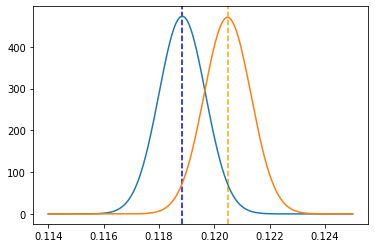

In [239]:
xA = np.linspace(.114, .125, 1000)
yA = stats.norm(p_A, SE_A).pdf(xA)

xB = np.linspace(.114, .125, 1000)
yB = stats.norm(p_B, SE_B).pdf(xB)

plt.axvline(x=p_A,ls="--",c="blue")
plt.axvline(x=p_B,ls="--",c="orange")

plt.plot(xA, yA)
plt.plot(xB, yB)

In the diagram, we can the area behind the orange dash line but under the blue curve is also quite small.  
  
But the y in the above diagram is the density of different conversion rate, so I generate two group of data through generating data randomly from normal distrubtion with each group's conversion rate and standard deviation. 

In [240]:
simulation_A = np.random.normal(p_A, SE_A, 2000)
simulation_B = np.random.normal(p_B, SE_B, 2000)

In [241]:
# f-tests
stats.levene(simulation_A, simulation_B)

LeveneResult(statistic=0.34274741510698875, pvalue=0.5582806811950027)

In [242]:
# t-tests
stats.ttest_ind(simulation_B, simulation_A, equal_var=False)

Ttest_indResult(statistic=62.25471129546437, pvalue=0.0)

The p value is also showed as 0 which represents we should reject the null hypothesis and the conversion rate of two group is significant different.

## Summary
Through our A/B test for both converted number of user and conversion rate, we get both quite small p value in t test. We should confirm the difference showing of vehicles' color in landing page is helpful. The colourful showing of vehicles on page might can stimulate user's interesting to see more details and then lead to the increased probabilty of purchase.